In [126]:
import pandas as pd 
import numpy as np 
from misc import * 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [3]:
btc_df = pd.read_csv('btcusd.csv')
eth_df = pd.read_csv('ethusd.csv')

In [4]:
display(btc_df.head())
display(eth_df.head())

,time,open,close,high,low,volume
0,1364774820000,93.25,93.30,93.30,93.25,93.300000
1,1364774880000,100.00,100.00,100.00,100.00,93.300000
2,1364774940000,93.30,93.30,93.30,93.30,33.676862
3,1364775060000,93.35,93.47,93.47,93.35,20.000000
4,1364775120000,93.47,93.47,93.47,93.47,2.021627


,time,open,close,high,low,volume
0,1457539440000,10.297,10.097,10.297,10.097,0.03
1,1457545740000,11.197,11.197,11.197,11.197,0.01
2,1457549760000,11.097,11.097,11.097,11.097,0.02
3,1457554560000,11.195,11.195,11.195,11.195,0.01
4,1457554860000,10.870,10.870,10.870,10.870,1.00


The time column needs to be converted.

In [7]:
def convert_to_datetime(df):
    X = df.copy()
    X['time'] = pd.to_datetime((X['time']*1e-3).astype('int64'),unit='s')
    X.set_index('time', inplace=True)
    return X

In [8]:
btc = convert_to_datetime(btc_df)
eth = convert_to_datetime(eth_df)

In [10]:
coins = dict()
coins['btc'] = btc
coins['eth'] = eth

### Checking missing dates

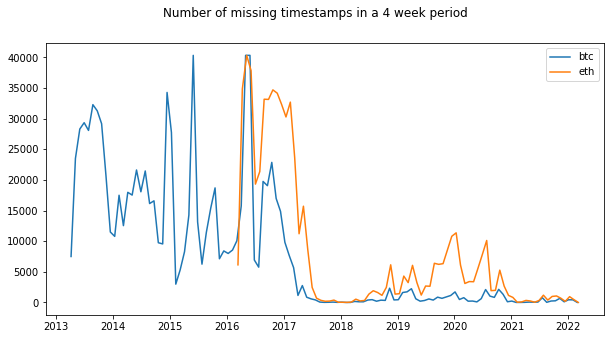

In [22]:
fig, ax =  plt.subplots(1,1, figsize=(10,5))

for coin, df in coins.items():
    missing_values = pd.date_range(start=df.index[0], end=df.index[-1], freq='60s').difference(df.index).to_frame()
    
    ax.plot(missing_values.resample('4W').count(),label=coin)
    
ax.legend()
fig.suptitle('Number of missing timestamps in a 4 week period')
plt.show()

A lot oof missing data from ETH at the start. Best to start the data from around 2018. 

In [26]:
START_DATE = pd.to_datetime('2018-01-01')

for coin, df in coins.items():
    coins[coin] = df.loc[START_DATE:]

### Imputing the missing timestamps

For now the missing data will be padded. For future improvements it would be good to investigate the reasons for the large amount of missing data for ETH in 2020. 

In [27]:
for coin, df in coins.items():
        new_index = pd.date_range(start=df.index[0], end=df.index[-1], freq='60s')
        coins[coin] = df.reindex(new_index,method='pad')
    

In [34]:
print('amount of time stamps:', coins['btc'].shape[0])
(coins['btc'].index[-1] - coins['btc'].index[0])/pd.Timedelta('60s')

amount of time stamps: 2166253


2166252.0

### Inspecting the closing price

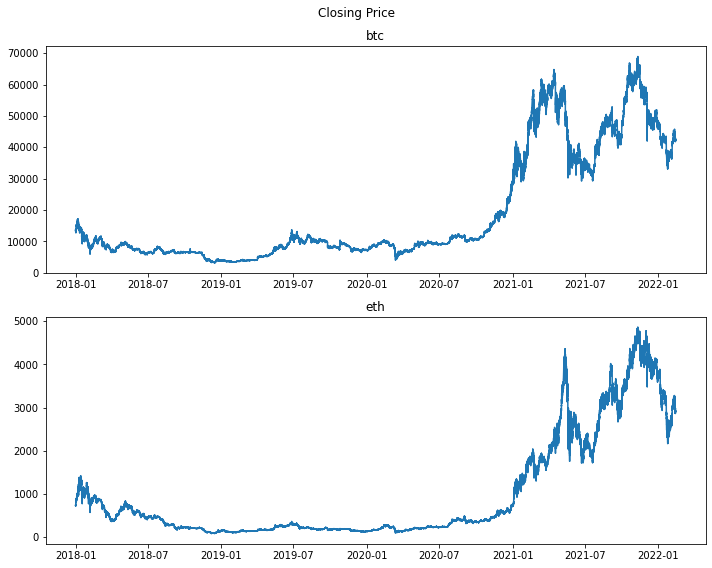

In [53]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

for i, (coin, df) in enumerate(coins.items()):
    ax[i].plot(df.close)
    ax[i].set_title(coin)
    
fig.suptitle('Closing Price')
plt.tight_layout()
plt.show()
    

They look to be closely correlated over time. Let's inspect it. 

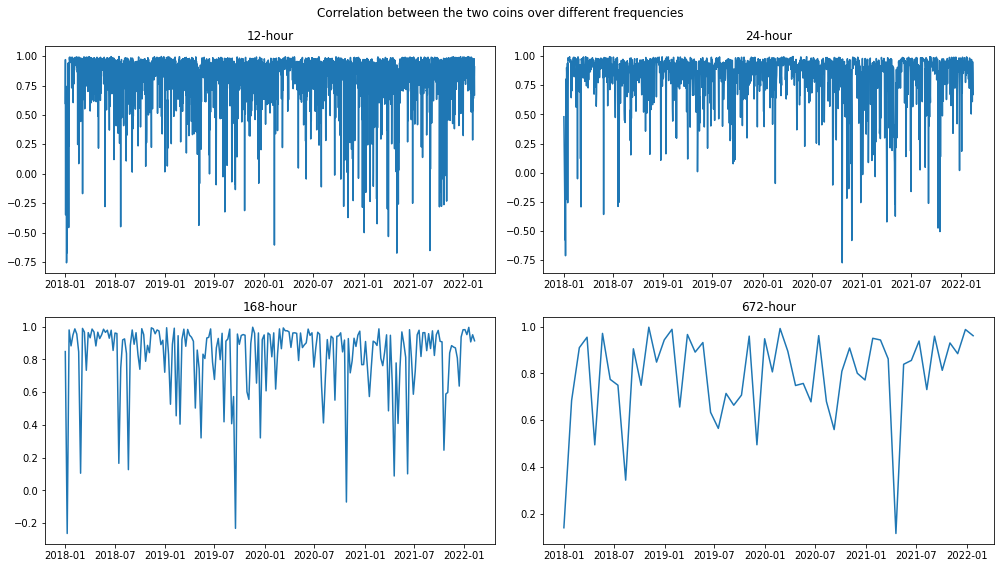

In [56]:
# lists all frequencies within which correlation will be calculated, in hours
corr_frequency = [12, 24, 7*24, 4*7*24]

two_assets = pd.concat([df.close for df in coins.values()], axis=1, keys=[coin for coin in coins.keys()])

rows = int(np.ceil(len(corr_frequency)/2))

fig, ax = plt.subplots(rows, 2, figsize=(14,8))

for i, freq in enumerate(corr_frequency):
    corr = two_assets.groupby(pd.Grouper(freq=f'{freq}H')).corr().loc[:,'btc'].loc[:,'eth']
    
    ax[i//2][i%2].plot(corr)
    ax[i//2][i%2].set_title(f'{freq}-hour')
    
plt.suptitle('Correlation between the two coins over different frequencies')
plt.tight_layout()
plt.show()

    
    

### Periodicity 
Checking for seasonality, trend etc 

In [87]:
# only look at the last year to decrease computation time
LAST_YEAR = coins['btc'].index[-1] - pd.Timedelta('365D')

btc_last_year = coins['btc'].loc[LAST_YEAR:, 'close']

/tmp/ipykernel_8135/3903490047.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(btc_last_year)


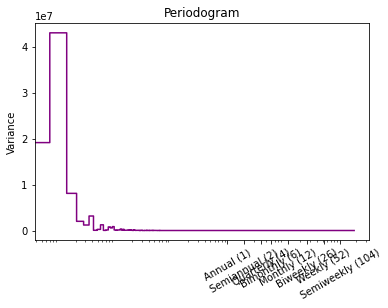

In [91]:
plot_periodogram(btc_last_year)
plt.show()

Seemingly no periodicity within the series. 

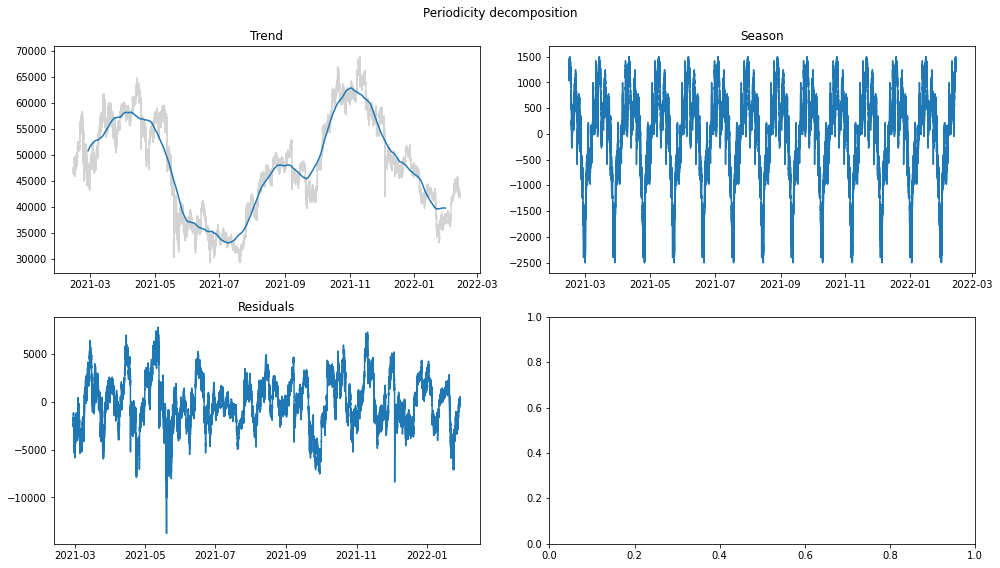

In [99]:
btc_sd = seasonal_decompose(btc_last_year, period=60*24*7*4)
btc_trend = btc_sd.trend
btc_detrended = btc_last_year - btc_trend
btc_seasonality = btc_sd.seasonal
btc_resid = btc_sd.resid

fig, ax = plt.subplots(2,2, figsize=(14,8))

ax[0,0].plot(btc_last_year, color='lightgrey')
ax[0,0].plot(btc_trend)
ax[0,0].set_title('Trend')

ax[0,1].plot(btc_seasonality)
ax[0,1].set_title('Season')

ax[1,0].plot(btc_resid)
ax[1,0].set_title('Residuals')

fig.suptitle('Periodicity decomposition')
plt.tight_layout()
plt.show()

Unsurprisingly little seasonlity. 

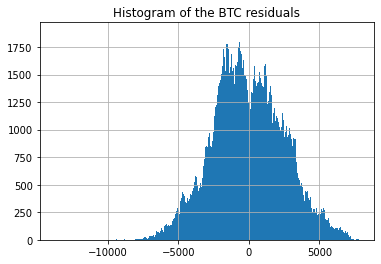

In [103]:
btc_resid.hist(bins=1000)
plt.title('Histogram of the BTC residuals')
plt.show()



### Stationarity, ACF and PACF

It's obvious from the graphs above that the BTC price time series is not stationary. It's most likely following a random walk like most asset prices. Below we check that is the case. 

In [120]:
print(btc_resid.shape)
check_stationarity(btc_resid.fillna(0).resample('600s').mean())

(525601,)
ADF Statistic: -6.637928
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


In [121]:
check_stationarity(btc_last_year.resample('600s').mean())

ADF Statistic: -1.884952
p-value: 0.339173
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


In [123]:
check_stationarity(btc_last_year.diff(periods=1).dropna().resample('600s').mean())

ADF Statistic: -45.215515
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


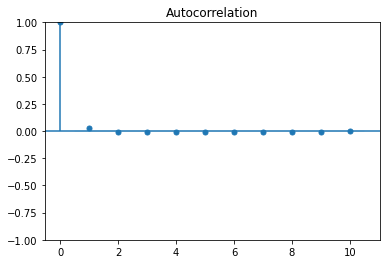

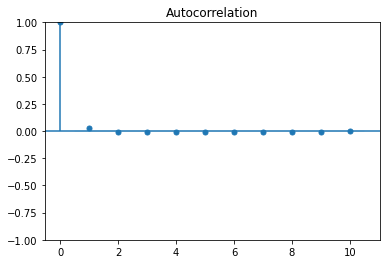

In [131]:
plot_acf(btc_last_year.diff(periods=1).dropna(),lags=10)

/home/mikiu/anaconda3/envs/crypt_venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


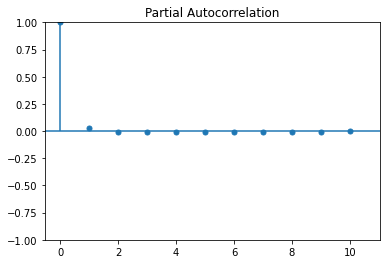

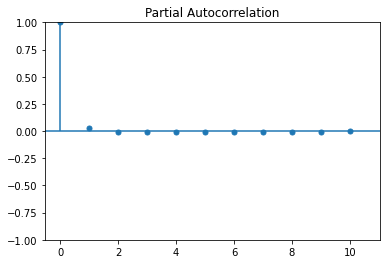

In [132]:
plot_pacf(btc_last_year.diff(periods=1).dropna(),lags=10)

#### Random walk behaviour as expected!

### Log Returns 

In [136]:
for coin, df in coins.items():
    coins[coin]['log_rtrn'] = log_return(df.close)
    coins[coin].dropna(inplace=True)

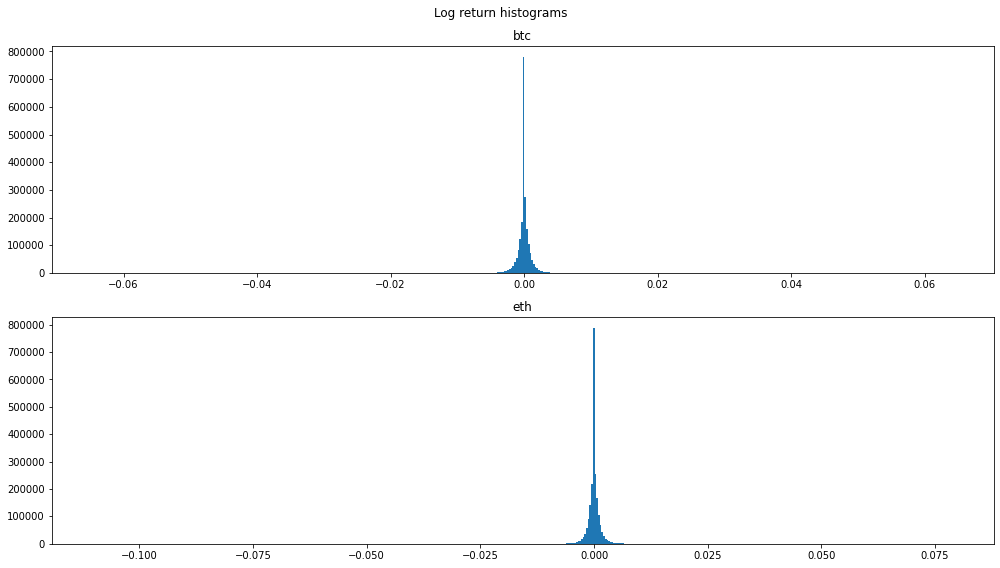

In [138]:
fig, ax = plt.subplots(2,1, figsize=(14,8))

for i, (coin,df) in enumerate(coins.items()):
    ax[i].hist(df['log_rtrn'],bins=500)
    ax[i].set_title(coin)
    
fig.suptitle('Log return histograms')
plt.tight_layout()
plt.show()

### Very fat tails!

In [147]:
for coin, df in coins.items():
    print(f'{coin} - mean:{df.log_rtrn.mean():.5f} min:{df.log_rtrn.min():.5f}, max: {df.log_rtrn.max():.5f}')
    print(f'{coin} - skew:{df.log_rtrn.skew():.5f} kurtosis:{df.log_rtrn.kurtosis():.5f}\n')
    

btc - mean:0.00000 min:-0.06433, max: 0.06392
btc - skew:0.04606 kurtosis:93.67887

eth - mean:0.00000 min:-0.10986, max: 0.07847
eth - skew:-0.43358 kurtosis:89.60136



In [150]:
for coin, df in coins.items():
    print(coin)
    check_stationarity(df.log_rtrn.loc[LAST_YEAR:].resample('600s').mean())

btc
ADF Statistic: -32.750360
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary
eth
ADF Statistic: -32.248685
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


/home/mikiu/anaconda3/envs/crypt_venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/mikiu/anaconda3/envs/crypt_venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


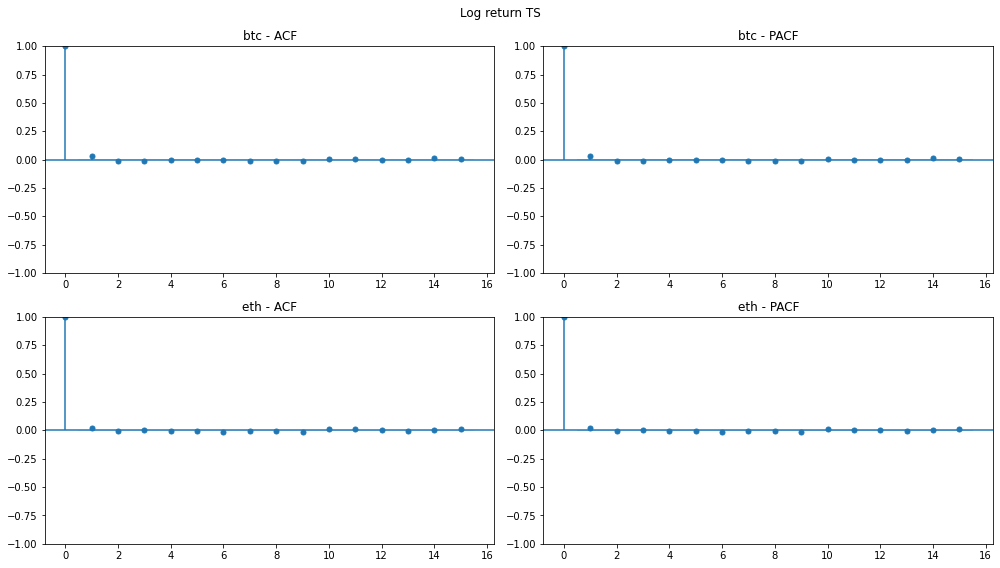

In [152]:
fig, ax = plt.subplots(2,2, figsize=(14,8))

for i, (coin, df) in enumerate(coins.items()):
    temp = df.loc[LAST_YEAR:, 'log_rtrn']
    plot_acf(temp, ax=ax[i,0], lags=15)
    plot_pacf(temp, ax=ax[i,1], lags=15)
    ax[i,0].set_title(coin + ' - ACF')
    ax[i,1].set_title(coin + ' - PACF')

fig.suptitle('Log return TS')
plt.tight_layout()
plt.show()

Confirmation that the log returns time series for both coins follows a random walk. 